<a href="https://colab.research.google.com/github/kellydingzx/ecg_notebooks/blob/main/Simple_AF_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download databases and Import libraries

In [ ]:
! wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/

In [ ]:
! wget -r -N -c -np https://physionet.org/files/nsrdb/1.0.0/
! wget -r -N -c -np https://physionet.org/files/afdb/1.0.0/

In [ ]:
import pip
import os

try:
    import wfdb
except ModuleNotFoundError:
    pip.main(['install', "wfdb"])
    import wfdb

import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
! pip install neurokit2

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Functions

In [135]:
# def get_peaks(sample_path, leads, fs):
#     signal, rest = wfdb.rdsamp(sample_path, sampfrom=0, sampto=60*60*fs*2, 
#                                 channel_names = leads)
#     cleaned = nk2.ecg_clean(signal, fs, method='neurokit2')
#     signals, info = nk2.ecg_peaks(cleaned, fs, method='neurokit2')

#     return info["ECG_R_Peaks"]
def get_peaks(sample_path, leads, fs):
    annots = wfdb.rdann(sample_path, 'atr', sampfrom=0, sampto=None)

    return annots.sample 

def get_rr_drr(peaks, fs):
    rr_intervals = np.diff(peaks)
    rr_intervals = np.divide(rr_intervals, fs)
    d_rr = np.diff(rr_intervals)

    return rr_intervals[1:], d_rr

In [136]:
def get_nec(plot_x, plot_y):
    x_min, x_max = min(plot_x), max(plot_x)
    y_min, y_max = min(plot_y), max(plot_y)

    x_min = 200 if x_min<200 else x_min
    y_min = -1000 if y_min<-1000 else y_min
    x_max = 2000 if x_max>2000 else x_max
    y_max = 2000 if y_max>2000 else y_max

    x_start, x_fin = (x_min//25-1)*25 , (x_max//25+1)*25
    y_start, y_fin = (y_min//25-1)*25, (y_max//25+1)*25

        
    nec = 0
    for x_i in range(int(x_start), int(x_fin), 25):
        for y_i in range(int(y_start), int(y_fin), 25):
          if np.any((plot_x >= x_i) & (plot_x < x_i + 25) & 
                  (plot_y >= y_i) & (plot_y < y_i + 25)):
            nec += 1
            # x_ind = np.where(np.logical_and(plot_x>=x_i, plot_x<x_i+25))[0]
            # y_ind = np.where(np.logical_and(plot_y>=y_i, plot_y<y_i+25))[0]
            # in_box = np.intersect1d(x_ind, y_ind)
            # if len(in_box)>0: nec+=1
    
    return nec

In [168]:
def full_nec(example_path, leads, fs, window_size):

    peak_idx = get_peaks(example_path, leads, fs)
    annots = wfdb.rdann(example_path, 'atr', sampfrom=0, sampto=None)
    af_idx = []
    for i in range(len(annots.sample)):
      if annots.symbol[i] != 'N':
        af_idx.append(annots.sample[i])

    # print(len(af_idx), len(annots.sample))
    nec_records = {}
    for i in range(0, len(peak_idx)-window_size, window_size+1):
        peak_chosen = peak_idx[i:i+window_size+1]
        rr, drr = get_rr_drr(peak_chosen, fs)
        plot_x = rr*1000
        plot_y = drr*1000
        nec = get_nec(plot_x, plot_y)
        segment = (peak_chosen[0], peak_chosen[-1])
        nec_records[segment] = nec
    
    return nec_records, af_idx

In [138]:
def get_nsr(nec_records, opti):
   counts = 0
   for seg, nec in nec_records.items():
     if nec > opti:
       counts += 1
   return counts/len(nec_records)

In [179]:
def get_results(nec_records, af_idx, opti):
    true_pos, true_neg, false_pos, false_neg = 0,0,0,0
    for seg, nec in nec_records.items():
        found = np.where(np.logical_and(af_idx>seg[0],af_idx<seg[1]))[0]
        if nec > opti and len(found) != 0:
            true_pos += 1
        elif nec <opti and len(found) == 0:
            true_neg +=1
        elif nec<opti and len(found)!=0:
            false_neg +=1
        elif nec>opti and len(found) == 0:
            false_pos +=1
    return true_pos, true_neg, false_pos, false_neg

In [172]:
def get_stats(true_pos, true_neg, false_pos, false_neg):
    sensitivity = None if true_pos+false_neg == 0 else true_pos/(true_pos+false_neg)
    specificity = None if true_neg+false_pos == 0 else true_neg/(true_neg+false_pos)
    # ppv = true_pos/(true_pos+false_pos)
    # f1 = None if sensitivity == None or ppv==0 else 2*ppv*sensitivity/(ppv+sensitivity)
    return sensitivity, specificity

In [141]:
def af_analyse(nec_records, af_idx, window_size, opti):
    tp, tn, fp, fn = get_results(nec_records, af_idx, opti)
    sen, spe = get_stats(tp, tn, fp, fn)
    return sen, spe

In [142]:
def nsr_analyse(example_path, leads, fs, window_size, opti):
    nec_records, _ = full_nec(example_path, leads, fs, window_size)
    counts = get_nsr(nec_records, opti)
    return counts

## Tests

In [ ]:
#  true_pos, true_neg, false_pos, false_neg

In [195]:
model_save_name = str(106)+'-'+'ECG1'+'-'+str(32)+'.npz'
path = F"/content/gdrive/My Drive/1 nec/{model_save_name}" 
saved = np.load(path, allow_pickle=True)
nec = saved['nec'].item()
af = saved['af']
for i in range(10, 30):
  a, b, c, d = get_results(nec, af, i)
  print(get_stats(a, b, c, d))

(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(0.9795918367346939, 0.0)
(0.96, 0.0)
(0.9591836734693877, 0.0)
(0.9387755102040817, 0.0)
(0.9183673469387755, 0.0)
(0.8936170212765957, 0.0)
(0.8222222222222222, 0.0)
(0.7291666666666666, 0.15384615384615385)
(0.6938775510204082, 0.16666666666666666)
(0.6363636363636364, 0.2727272727272727)
(0.5217391304347826, 0.45454545454545453)
(0.3953488372093023, 0.7)
(0.26666666666666666, 1.0)


In [146]:
paths = '/content/physionet.org/files/mitdb/1.0.0/100'
annots = wfdb.rdann(paths, 'atr', sampfrom=0, sampto=None)

In [ ]:
x = annots.symbol
x

In [143]:
import os
arr = os.listdir('/content/physionet.org/files/mitdb/1.0.0/')

sample_ids = []
for file in arr:
    if '.atr' in file:
      current_id = int(file[:3])
      if current_id not in sample_ids:
        sample_ids.append(current_id)
sample_ids.sort()

# sample_ids.remove(int('03665'))
# sample_ids.remove(int('00735'))
# sample_ids.remove(int('04043'))

all_ids = list(set(sample_ids)) 

In [169]:
result = {}

for win in [32, 64, 128]:
  for lead in ['ECG1', 'ECG2']:
    nec = []
    for id in all_ids:
      str_id = str(id)
      # if len(str_id)<5:
      #   str_id = '0'*(5-len(str_id)) + str_id
  
      nec, af = full_nec('/content/physionet.org/files/mitdb/1.0.0/'+str_id, [lead], 250, win)
      model_save_name = str(id)+'-'+lead+'-'+str(win)+'.npz'
      path = F"/content/gdrive/My Drive/1 nec/{model_save_name}" 
      np.savez(path, nec=nec, af=af)

In [170]:
import pandas as pd

In [173]:
df_sen = pd.DataFrame(0.0, index=range(1, 128), columns=[32, 64, 128])
df_spe = pd.DataFrame(0.0, index=range(1, 128), columns=[32, 64, 128])

for win in [32, 64, 128]:
  for opti in range(1, win):
    sens = []
    spes = []
    for id in all_ids:
      for lead in ['ECG1', 'ECG2']:
        model_save_name = str(id)+'-'+lead+'-'+str(win)+'.npz'
        path = F"/content/gdrive/My Drive/1 nec/{model_save_name}" 
        saved = np.load(path, allow_pickle=True)
        nec = saved['nec'].item()
        af = saved['af']
  
        sen, spe = af_analyse(nec, af, win, opti)
        if sen == None or spe == None:
          break
        sens.append(sen)
        spes.append(spe)
    print((np.mean(sens), np.mean(spes)))
    df_sen.loc[opti, win] = np.mean(sens)
    df_spe.loc[opti, win] = np.mean(spes)
      

(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0004608294930875576)
(0.999624060150376, 0.009038769785614105)
(0.9996190476190475, 0.026933944709649847)
(0.9985578231292518, 0.06690694031907236)
(0.9913748107938828, 0.10604446767386261)
(0.9772238699487774, 0.12860275239144192)
(0.9612314176811262, 0.16220583930737173)
(0.9405531720886829, 0.17965437748869204)
(0.9164312884603565, 0.19983538394309486)
(0.8970425782779605, 0.23293188092101136)
(0.8577445404912662, 0.27555688638902415)
(0.813158300102607, 0.3224777913359228)
(0.7907193591379654, 0.3985807364876465)
(0.7652016353397755, 0.44119664675871945)
(0.7196899120780611, 0.46774866786576175)
(0.662137510975407, 0.4926004785190375)
(0.6115201660914663, 0.5241477748154767)
(0.5653311221620402, 0.552858165411605)
(0.5012332595139367, 0.5869970724823342)
(0.45488045290355683, 0.6138556599724767)
(0.3960071162529, 0.6463287161167423)
(0.30121897753868687, 0.6968408666708763)
(0.19861071556578958, 0.77538452822

In [174]:
df_sen.to_csv("/content/gdrive/My Drive/1 nec/sen.csv" )
df_spe.to_csv("/content/gdrive/My Drive/1 nec/spe.csv" )

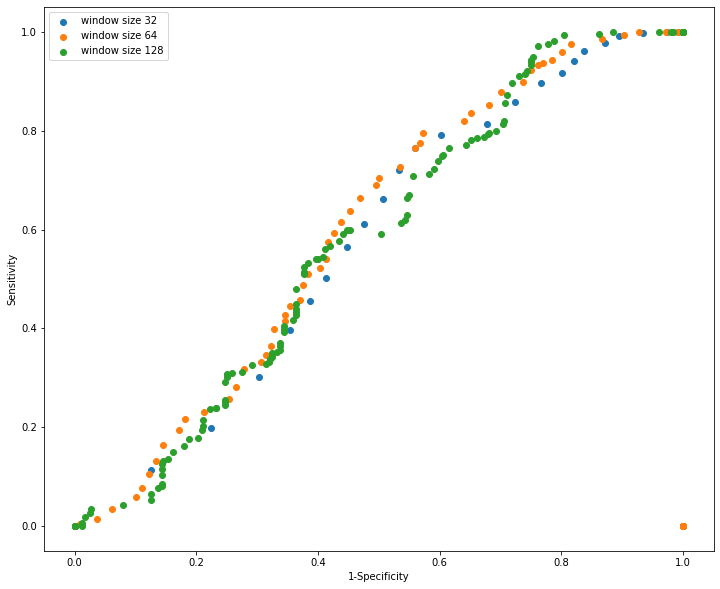

In [191]:
y = df_sen[32].values
x = 1- df_spe[32].values

plt.figure(figsize=(12,10))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.scatter(1-df_spe[32].values, df_sen[32].values, label='window size 32')
plt.scatter(1-df_spe[64].values, df_sen[64].values, label='window size 64')
plt.scatter(1-df_spe[128].values, df_sen[128].values, label='window size 128')

plt.legend()